## <center> Практическое домашнее задание 3 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 16.04.2025

Первый дедлайн: 07:59MSK 18.05.2025

Второй дедлайн: 07:59MSK 20.05.2025

### Оглавление

В этом задании вы:

1. [ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии](#введение)
2. [познакомитесь с калибровкой вероятности](#калибровка)
3. [изучите методы трансформации переменных и методы отбора признаков](#кодировка)
4. [попробуете оценить экономический эффект модели](#модель)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

❗️ Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо **указать ссылку на этот источник**.

**❗️ При использовании генеративных нейросетей:**

1. Необходимо указывать их как источник в каждом соответствующем задании
2. Ассистенты могут проводить мини-защиты ДЗ
3. Без указания как источника и подозрениях ассистентов, задания будут так же защищаться, иначе обнуляться.

# Часть 1. SVM, LR и калибровка вероятностей<a name="введение"></a>

*Максимум: 3 балла*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (1 балл)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier


random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?

**Ваш Ответ**: predict_proba возвращает вероятность принадлежности соответствующего объекту к классу. predict_proba возвращает матрицу - по столбцам класс, по строкам - объекты, в ячейке $a_{ij}=P(x_i\inКласс_j)$ то есть вероятность принадлежности элемента i к классу j. Так как мы обрезаем индексацией: [:,1] лишь столбик соответствующий вероятности принадлежности к классу "0". Очевидно, что для бинарного класссификатора каждый элемент второго столбика $a_{i1}$ был бы равен $a_{i1}=1-a_{i0}$

Если нужно было вернуть предсказанные метки, надо было использовать функцию predict().

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


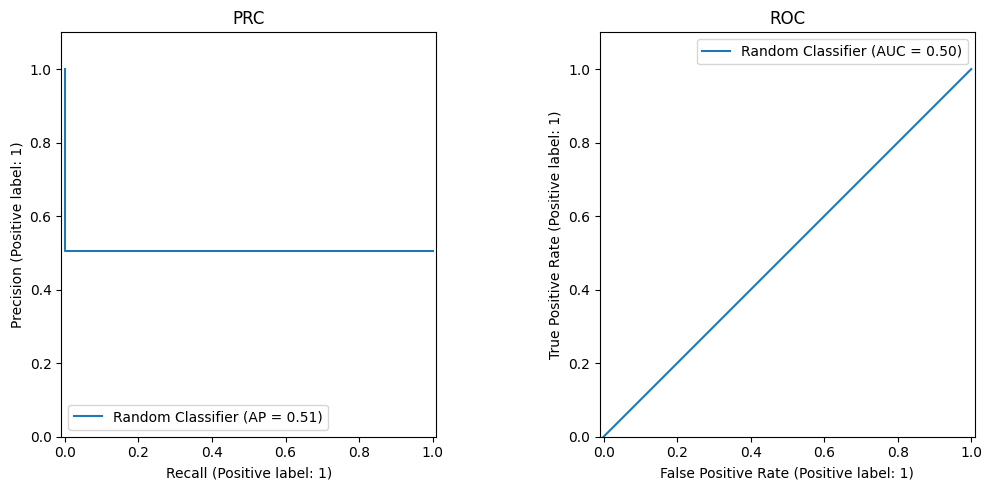

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None, alpha=1):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name, alpha=alpha)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name, alpha=alpha)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()

    return auc(recall, precision), roc_auc_score(y_true, y_pred)


pr_random,roc_random = depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# DataFrame для сравнения методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)

# Добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [ ]:
C_value    = np.logspace(-3, 3, 7)  # (.... your code here)

svm = LinearSVC(random_state=42)
C_searcher = GridSearchCV(
    estimator=svm,
    param_grid={'C': C_value},
    scoring=make_scorer(average_precision_score), # Выбираем по ТЗ лучший параметр регуляризации C по PR кривой
    cv=5 # Кросс валидация - бьется на 5 блоков, на 4х обучаем, 5 - тестовый. Так 5 раз (каждый раз тестовый блок меняется). В качестве результата выдаем среднее по 5 экспериментам
)


Тут надо прояснить момент, как для предсказаний SVM строится кривая ROC-PR, ведь SVM строит разделяющую плоскость, а не говорит вероятностный прогноз для конкретного объекта.

В качестве данных для PR кривой используются расстояния до разделяющей плоскости SVM'а. Метрика average_precision_score строит PR кривую по отсортированным (ранжированным) по значению расстояниям до разделяющей плоскости для каждого объекта.  

In [ ]:
C_searcher.fit(X_train, y_train)  # Подбор C

GridSearchCV(cv=5, estimator=LinearSVC(random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=make_scorer(average_precision_score, response_method='predict'))

In [ ]:
best_C   = C_searcher.best_params_['C'] # .... your code here
svc_pred = C_searcher.decision_function(X_test) # предсказываем

print("Best C value = %.4f" % best_C)
print('SVC AUC-PR:', average_precision_score(y_test, svc_pred))

Best C value = 0.0010
SVC AUC-PR: 0.8295589687319155


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Linear SVM, C=0.001 metrics
AUC-PR: 0.82930
AUC-ROC: 0.84742


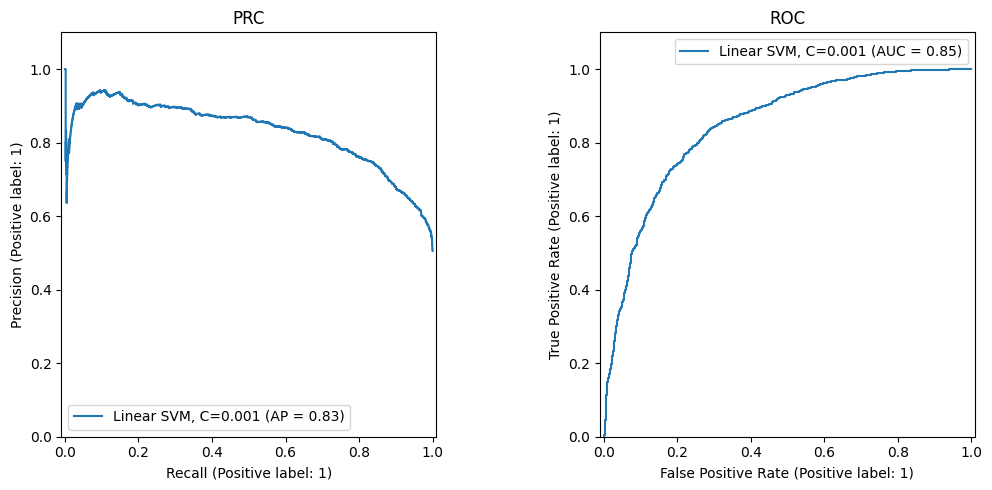

In [ ]:
pr_SVM, roc_SVM = depict_pr_roc(y_test,svc_pred,f'Linear SVM, C={best_C}')
# .... your code here

Здесь кривая PR не монотонно убывает. Это связано с тем что Precision при увеличении порога treshold убывает не монотонно.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
# .... your code here
print(f"SVM: AUC-ROC = {roc_SVM:.5f}, AUC-PR = {pr_SVM:.5f}")
print(f"Random: AUC-ROC = {roc_random:.5f}, AUC-PR = {pr_random:.5f}\n")

# Сравнение ROC
if roc_SVM > roc_random:
    print(f"SVM лучше Random по AUC-ROC на {(roc_SVM - roc_random):.3f}")
elif roc_SVM < roc_random:
    print(f"Случайный классификатор лучше SVM по AUC-ROC (это невозможно для SVM)")
else:
    print("Модели равны по AUC-ROC")

# Сравнение PR
if pr_SVM > pr_random:
    print(f"SVM лучше Random по AUC-PR на {(pr_SVM - pr_random):.3f}")
elif pr_SVM < pr_random:
    print(f"Случайный классификатор лучше SVM Random по AUC-PR (SVM работает хуже случайного!)")
else:
    print("Модели равны по AUC-PR")


SVM: AUC-ROC = 0.84742, AUC-PR = 0.82930
Random: AUC-ROC = 0.50000, AUC-PR = 0.75283

SVM лучше Random по AUC-ROC на 0.347
SVM лучше Random по AUC-PR на 0.076


**Интерпретация результатов сравнения классификатора SVM и случайного**

Бинарная классификация с помощью SVM лучше по ROC-AUC:
*   SVM предсказывает классы лучше чем случайный классификатор (вероятность для конкретного объекта быть угаданным с помощью SVM выше, чем если мы случайно сопоставим ему один из двух классов)
Бинарная классификация с помощью SVM лучше по AUC-PR:
*   PR имеет преимущество для выборок с малопредставленным количестом одного из классов (дизбалансом классов). Модель SVM хорошо находит мало представленные в выборке классы (к примеру болезни) - то есть высокий Recall. Среди элементов помеченных моделью как принадлежащими к малопредставленному классу - действительно много истинно предсказанных (это высокий Precision).



__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
# .... your code here
from sklearn.linear_model import LogisticRegression

C_values = np.logspace(-3, 3, 7) # C = 1/Lambda

lr = LogisticRegression(penalty='l2', random_state=42, max_iter=1000) # В логистическую регрессию по ТЗ добавим L2 Регуляризатор

def pr_auc_score_proba(estimator, X, y): # Скорее всего, в моей версии не работает правильно needs_proba, поэтому для использования такого же функционала написал функцию-метрику pr
    probas = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, probas)

lr_searcher = GridSearchCV(
    estimator=lr,
    param_grid={'C': C_values},
    scoring=pr_auc_score_proba, # needs_proba говорит использовать вероятности предсказанных классов а не сами метки (predict_proba вместо predict)
    cv=5 # Снова Cross-Fold валидация с 5 равными группами
)

lr_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=<function pr_auc_score_proba at 0x784d88325f80>)

In [ ]:
# Посмотрим таблицу с train-оценками
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results[['param_C', 'mean_train_score', 'mean_test_score']].sort_values('mean_train_score', ascending=False)

,param_C,mean_train_score,mean_test_score
6,0.001,0.827963,0.827725
5,0.010,0.823587,0.823628
4,0.100,0.822642,0.822606
3,1.000,0.822527,0.822480
2,10.000,0.822516,0.822471
1,100.000,0.822514,0.822468
0,1000.000,0.822514,0.822468


In [ ]:

best_Lambda = lr_searcher.best_params_['C']
lr = LogisticRegression(penalty='l2', random_state=42, max_iter=1000, C = best_Lambda)
lr.fit(X_train, y_train)

logreg_pred = lr_searcher.predict_proba(X_test)[:, 1] # предсказываем

print("Best Lambda value = %.4f (Параметр регуляризации, в Sklearn он называется C)" % best_Lambda)
print('Logistic Regression AUC-PR:', average_precision_score(y_test, logreg_pred))


Best Lambda value = 0.0010 (Параметр регуляризации, в Sklearn он называется C)
Logistic Regression AUC-PR: 0.8337565527948128


Logistic Regression metrics
AUC-PR: 0.83360
AUC-ROC: 0.84533


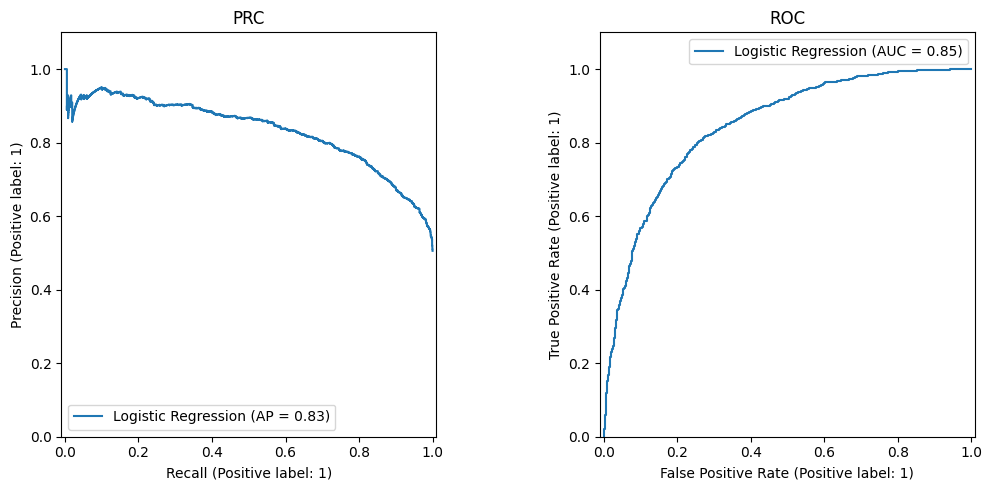

In [ ]:
y_lr_proba = lr_searcher.predict_proba(X_test)[:, 1]  # [:,1] — это вероятность класса 1
pr_lr, roc_lr = depict_pr_roc(y_test, y_lr_proba, 'Logistic Regression')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.83360
AUC-ROC: 0.84533
SVM metrics
AUC-PR: 0.82930
AUC-ROC: 0.84742
Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


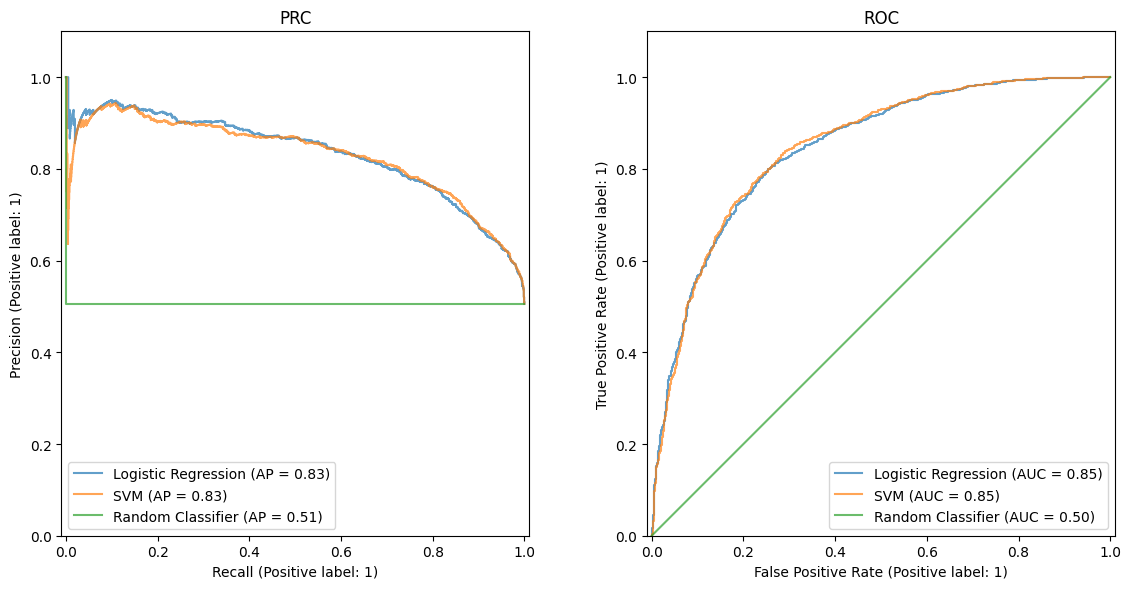

In [ ]:
# .... your code here
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Логистическая регрессия
depict_pr_roc(y_test, y_lr_proba, classifier_name='Logistic Regression', ax=ax, alpha=0.7)

# 2. SVM
depict_pr_roc(y_test, svc_pred, classifier_name='SVM', ax=ax, alpha=0.7)

# 3. Случайный классификатор
depict_pr_roc(y_test, y_random, classifier_name='Random Classifier', ax=ax, alpha=0.7)

plt.legend()  # отображение легенды
plt.show()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ваш Ответ:**


*   Видно, что метод SVM (SVC в данном случае, поскольку Classifier) работает с очень близкими метриками к Logistic Regression с регуляризацией L2. Это может быть связанно с тем что данные сгенерированы случайным образом (5 значимых признаков, 5 избыточных (линейные комбинации первых 5 признаков)), поэтому классы сбалансированы, и, по-видимому, хорошо разделяются гиперплоскостью. К примеру, если в одном из классов был перевес, потребовались бы нелинейные ядра, и классификаторы бы работали с разной степенью успешности.
*   Roc-Auc позволяет понять качество разделения классов, обе модели хорошо разделяют их, поскольку данные так сгенерированы. PR-кривая позволяет понять качество предсказания положительного класса "1", но поскольку у нас mean(y_test)=0.5 примерно, метрика не столь точна, и равна у обеих моделей.



#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)  <a name="калибровка"></a>

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
from sklearn.svm import SVC

X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, random_state=42)

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X, y)
support_vectors = svc_model.support_vectors_

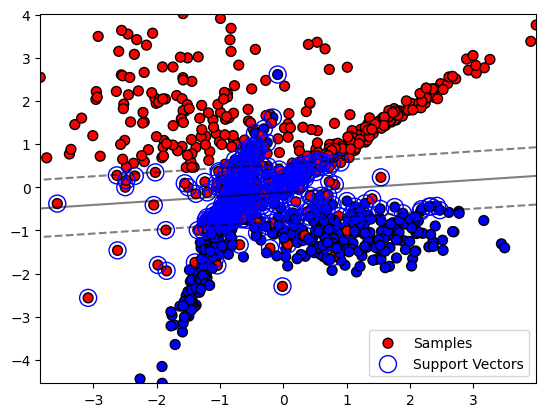

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы уже обученной модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку X
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr',
               edgecolors='k', s=50, label='Samples')

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150,
                   linewidth=1, edgecolor="blue",
                   facecolors='none', label='Support Vectors')

    plt.legend()

plot_svm_2D(X, y, svc_model)

Заметим, что в неразделимых случаях опорные вектора - объекты нашей выборки - далеко не всегда оказываются на границах зазора.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X, y)

LogisticRegression(random_state=42)

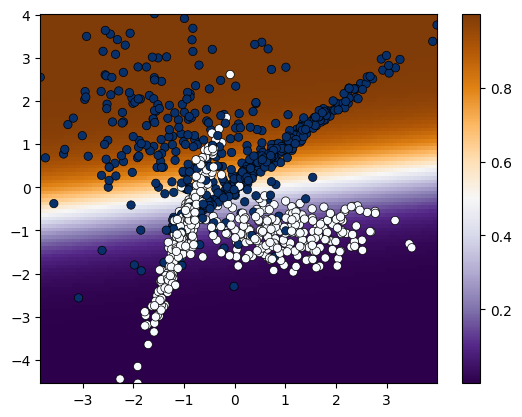

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Blues,
                edgecolors='k', linewidths=0.5)

    plt.colorbar(image)


plot_logreg_2D(X, y, logreg_model)

#### __Задание 2. Калибровка вероятностей__ (1.5 балла)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой используем следующий алгоритм:

- Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

- Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц.

- Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. **В ней допущено две ошибки — найдите и исправьте их.**

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
(svc_preds - svc_preds.min()) / (svc_preds.max() - svc_preds.min())

array([0.35132064, 0.07364439, 0.19355136, 0.05640935, 0.10235494,
       0.86658104, 0.00604093, 0.2705616 , 0.08778162, 0.1422433 ,
       0.49703096, 0.58442203, 0.13967192, 0.14582197, 0.59984972,
       0.11463776, 0.16525031, 0.39205164, 1.        , 0.9225801 ,
       0.10240478, 0.10157225, 0.22300325, 0.1628612 , 0.14192781,
       0.13287578, 0.1626559 , 0.73317298, 0.41181718, 0.12572692,
       0.18629119, 0.25117853, 0.09359066, 0.4318139 , 0.10476004,
       0.08955338, 0.4332229 , 0.12404032, 0.10987356, 0.14718364,
       0.09989028, 0.83490418, 0.35890922, 0.11976332, 0.0951425 ,
       0.11737081, 0.16533108, 0.16627841, 0.54013233, 0.12750815,
       0.47077899, 0.48110446, 0.28727124, 0.35186957, 0.09714507,
       0.72896676, 0.09878244, 0.14693192, 0.22826976, 0.18339827,
       0.17451633, 0.1401708 , 0.4858078 , 0.43494885, 0.59470413,
       0.44705024, 0.24425717, 0.12821437, 0.36839025, 0.11216881,
       0.17975012, 0.11971232, 0.12108824, 0.05203837, 0.20714

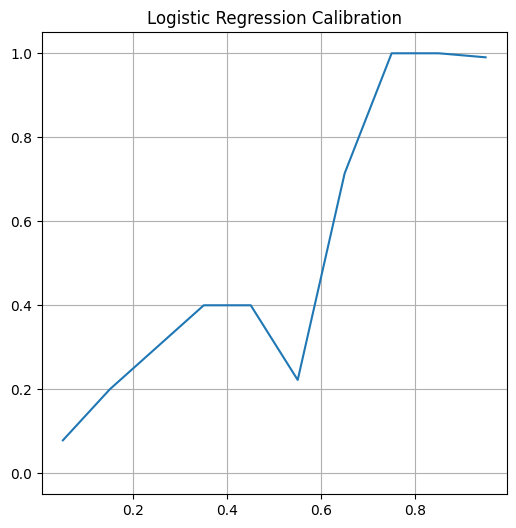

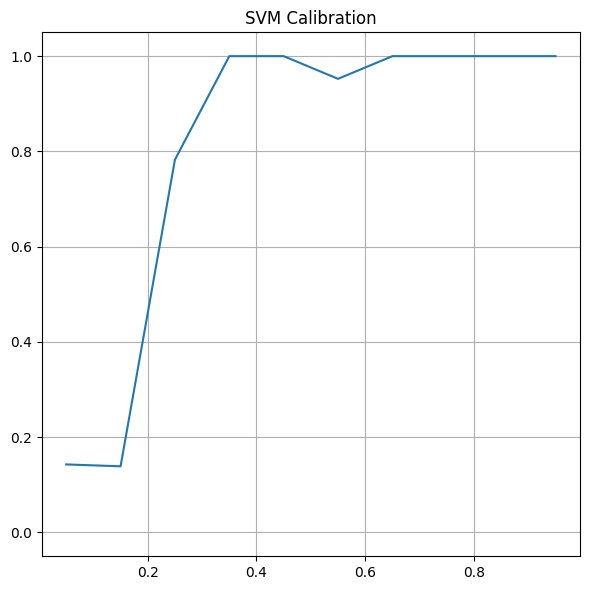

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_informative=2, random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_test)[:, 1]

svc_model = SVC(kernel='linear', probability=False, random_state=42).fit(X_train, y_train) # Хотел изначально указать probability=True для автоматической нормировки
# Но к сожалению, эта опция сразу калибрует вероятности, чего сейчас пока делать нельзя (опираясь на следующие задания).
# Отнормирую min/max способом
svc_preds = svc_model.decision_function(X_test)
svc_preds_normalized = (svc_preds - svc_preds.min()) / (svc_preds.max() - svc_preds.min())

# обучили - вероятности на тесте - графики .... your code here
plot_calibration_curve(y_test, lr_preds)
plt.title('Logistic Regression Calibration')
plot_calibration_curve(y_test, svc_preds_normalized)
plt.title('SVM Calibration')

plt.tight_layout()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ваш Ответ:**


*   По кривой Логистической регрессии видим, что в диапазоне $x\in[0,0.4]$ хорошо предсказывает вероятность (близко к y=x). Однако потом при $x=0.55$ идет просадка - модель слишком самоуверена, то есть количество реальных объектов с классом 1 среди тех, кому модель пророчит класс 1 с вероятностью 55% примерно 0.2, то есть модель завышает в этой точке статистику, идеальная модель бы заявила x=0.2. Дальше идет обратная ситуация - реальное количество объектов с классом 1 среди тех, которым модель осторожно заявляет класс $x\in[0.8,1]$ это 100%. Хотелось бы чтобы модель здесь говорила что x=1   
*   По кривой SVC мы видим всюду завышение над прямой y=x - Систематическая слишком большая осторожность. Модель боится сообщать класс 1, поскольку не уверена в этом ответе, хотя процент объектов с классом 1, которые модель считает маловероятными положительными классами близится к 80-100%. Положительный класс - класс "1". Модель неоткалибрована



Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

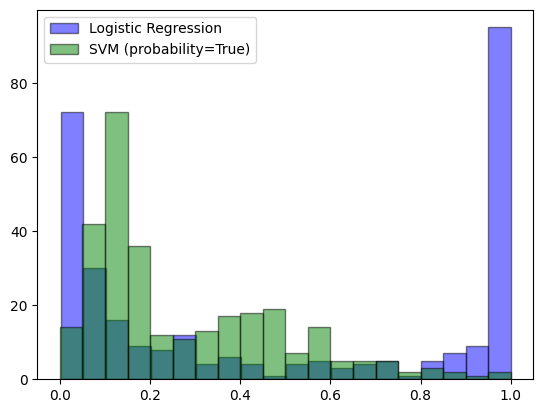

In [ ]:
plt.hist(lr_preds, bins=20, alpha=0.5, label='Logistic Regression', color='blue', edgecolor='black')
plt.hist(svc_preds_normalized, bins=20, alpha=0.5, label='SVM (probability=True)', color='green', edgecolor='black')
plt.legend()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ваш Ответ:**


*   Обе модели чаще всего предсказывают вероятности, близкие к 0 или 1, то есть делают уверенные предсказания
*   SVM имеет больше значений $P(x)\in[0.1, 0.3]$. Значит SVM чаще "сомневается" в своем ответе. Дело в том что Logistic Regression обучается сразу разделять вероятностно два класса, поэтому мы можем видеть, что основная масса ответов сконцентрирована близко к краям: P(x=1)=0 либо P(x=1)=1. Однако SVC обучался сначала как жесткий классификатор (да\нет), поэтому "предсказывать вероятность класса" умеет плохо.



Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
calibrated_clf = CalibratedClassifierCV(svc_model, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)

# 3. Получаем предсказания
svm_scores = svc_model.decision_function(X_test)  # Расстояния до гиперплоскости
svm_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]  # Калиброванные вероятности

Text(0.5, 1.0, 'SVM Calibration')

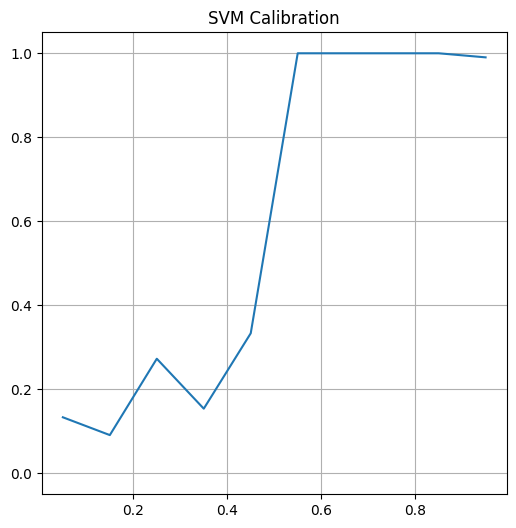

In [ ]:
plot_calibration_curve(y_test, svm_proba_calibrated)
plt.title('SVM Calibration')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ваш Ответ:**

Калибровочная кривая улучшилась, хоть в ней присутствуют резкие скачки (при $P(x=1)\in[0.6, 1]$ модель говорит что вероятность объекта оказаться классом 1 60%, 70%, когда на самом деле все объекты в этом срезе уже с классом 1). Однако нет повсеместного завышения над кривой y=x. Лучше совпадают калибровочная кривая и y=x



# Часть 2. Обработка категориальных переменных  <a name="кодировка"></a>


*Максимум: 6 баллов*

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед

- Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

- Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("heeraldedhia/bike-buyers")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bike-buyers


In [ ]:
df = pd.read_csv(path + "/" + 'bike_buyers.csv')

In [ ]:
df.head(10)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
5,13507,Married,Female,10000.0,2.0,Partial College,Manual,Yes,0.0,1-2 Miles,Europe,50.0,No
6,27974,Single,Male,160000.0,2.0,High School,Management,NaN,4.0,0-1 Miles,Pacific,33.0,Yes
7,19364,Married,Male,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,43.0,Yes
8,22155,NaN,Male,20000.0,2.0,Partial High School,Clerical,Yes,2.0,5-10 Miles,Pacific,58.0,No
9,19280,Married,Male,NaN,2.0,Partial College,Manual,Yes,1.0,0-1 Miles,Europe,NaN,Yes


In [ ]:
#Заменим пропуски категориальных переменных
cat_cols = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance','Region', 'Purchased Bike']
for col in cat_cols:
    df[col] = df[col].fillna('undefined')

numerical_cols = ['ID', 'Income', 'Children', 'Cars', 'Age']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median()) # Числовые пропуски заменяем медианой
df[cat_cols] = df[cat_cols].fillna('Unknown') # Категориальные пропуски заменяем на Unknown

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = X[numerical_cols]

cat_cols.remove('Purchased Bike')
X_categorical = X[cat_cols]


In [ ]:
# Проверка результатов
print("Числовые признаки:")
print(X_numerical.head())
print("\nКатегориальные признаки:")
print(X_categorical.head())
print("\nРаспределение целевой переменной:")
print(y.value_counts())

Числовые признаки:
      ID   Income  Children  Cars   Age
0  12496  40000.0       1.0   0.0  42.0
1  24107  30000.0       3.0   1.0  43.0
2  14177  80000.0       5.0   2.0  60.0
3  24381  70000.0       0.0   1.0  41.0
4  25597  30000.0       0.0   0.0  36.0

Категориальные признаки:
  Marital Status     Gender        Education      Occupation Home Owner  \
0        Married     Female        Bachelors  Skilled Manual        Yes   
1        Married       Male  Partial College        Clerical        Yes   
2        Married       Male  Partial College    Professional         No   
3         Single  undefined        Bachelors    Professional        Yes   
4         Single       Male        Bachelors        Clerical         No   

  Commute Distance   Region  
0        0-1 Miles   Europe  
1        0-1 Miles   Europe  
2        2-5 Miles   Europe  
3       5-10 Miles  Pacific  
4        0-1 Miles   Europe  

Распределение целевой переменной:
Purchased Bike
0    519
1    481
Name: count, dty

__Задание 2.1 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Что означает этот аргумент?

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=777, stratify=y
)
# stratify Сохраняет пропорции классов из y в обеих выборках (трэин, тест)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

* Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии.

* Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Для продажи велосипедов важны именно Precision (чтобы не тратиться в маркетинге на заведомо незаинтересованных покупателей), и Recall ("не пропустить" реальных покупателей). То есть мы выделяем интересующий нас класс покупателей велосипеда. Сейчас особого дизбаланса классов нет.

In [ ]:
print(X.isnull().sum())

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
dtype: int64


In [ ]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

start_timer = time.time()

# Создаем преобразователь для категориальных признаков
categorical_transformer = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Полный пайплайн с обработкой признаков и моделью
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', numerical_cols),
        ('cat', categorical_transformer, cat_cols)
    ])),
    ('classifier', LogisticRegression(max_iter=50000, random_state=777))
])

pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)
execution_time = time.time() - start_timer

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Время выполнения: {execution_time:.2f} секунд")

AUC-PR: 0.6832
Время выполнения: 1.18 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
# pipeline_ohe.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

32

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
start_time = time.time()

categorical_transformer_ohe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pipeline_ohe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', numerical_cols),
        ('cat', categorical_transformer_ohe, cat_cols)
    ])),
    ('classifier', LogisticRegression(max_iter=50000, random_state=777))
])
pipeline_ohe.fit(X_train, y_train)

y_pred_ohe = pipeline_ohe.predict_proba(X_test)[:, 1]
auc_pr_ohe = average_precision_score(y_test, y_pred_ohe)

time_ohe = time.time() - start_time

print(f"One-Hot Encoding: AUC-PR = {auc_pr_ohe:.4f}, Время = {time_ohe:.2f} сек")

print("\nРазмерность признаков после преобразования:")
print(f"One-Hot: {pipeline_ohe.named_steps['preprocessor'].transform(X_train[:1]).shape[1]} признаков")

NameError: name 'time' is not defined

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (2 балла)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
cat_cols

['Marital Status',
 'Gender',
 'Education',
 'Occupation',
 'Home Owner',
 'Commute Distance',
 'Region']

In [ ]:
start_time = time.time()

# Создаем копии данных чтобы не изменять оригиналы
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Словарь для хранения кодировок
encoding_dict = {}

# Применяем mean target encoding для каждого категориального признака
for col in cat_cols:
    temp_df = X_train.copy()
    temp_df['target'] = y_train
    encoding_dict[col] = temp_df.groupby(col)['target'].mean().to_dict() # Вычисляем по выданной в ТЗ формуле среднее значение для каждой категории
    X_train_encoded[col] = X_train[col].map(encoding_dict[col]) # Применяем кодирование к train и test к каждой колонке
    X_test_encoded[col] = X_test[col].map(encoding_dict[col])
    global_mean = y_train.mean() # Заменяем пропуски (новые категории) на среднее по всему датасету
    X_train_encoded[col] = X_train_encoded[col].fillna(global_mean)
    X_test_encoded[col] = X_test_encoded[col].fillna(global_mean)
# Объединяем с числовыми признаками
X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded[cat_cols]], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded[cat_cols]], axis=1)
# Обучаем логистическую регрессию
model = LogisticRegression(max_iter=50000, random_state=777)
model.fit(X_train_final, y_train)
# Предсказания и оценка
y_pred = model.predict_proba(X_test_final)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)
# Замер времени выполнения
encoding_time = time.time() - start_time

print(f"AUC-PR с Mean Target Encoding: {auc_pr:.4f}")
print(f"Время кодирования и обучения: {encoding_time:.2f} сек")

AUC-PR с Mean Target Encoding: 0.7145
Время кодирования и обучения: 2.41 сек


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:

start_time = time.time()

# Создаем копии данных чтобы не изменять оригиналы
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
encoding_dict = {} # Словарь для хранения кодировок
noise_level = 0.05 # Множитель дисперсии шума
# Применяем mean target encoding для каждого категориального признака
np.random.seed(42)
for col in cat_cols:
    temp_df = X_train.copy() # мы "не знаем" y_test, берем mean только по y_train
    temp_df['target'] = y_train
    encoding_dict[col] = temp_df.groupby(col)['target'].mean().to_dict() # Вычисляем по выданной в ТЗ формуле среднее значение для каждой категории
    # Добавляем шум только к train данным
    X_train_encoded[col] = X_train[col].map(encoding_dict[col])
    noise = np.random.normal(0, noise_level * X_train_encoded[col].std(), size=len(X_train))
    X_train_encoded[col] = X_train_encoded[col] + noise
    # Для test данных шум не добавляем
    X_test_encoded[col] = X_test[col].map(encoding_dict[col])
    global_mean = y_train.mean() # Заменяем пропуски (новые категории) на среднее по всему датасету
    X_train_encoded[col] = X_train_encoded[col].fillna(global_mean)
    X_test_encoded[col] = X_test_encoded[col].fillna(global_mean)

X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded[cat_cols]], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded[cat_cols]], axis=1)
# Обучаем логистическую регрессию
model = LogisticRegression(max_iter=50000, random_state=777)
model.fit(X_train_final, y_train)
# Предсказания и оценка
y_pred = model.predict_proba(X_test_final)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)
# Замер времени выполнения
encoding_time = time.time() - start_time

print(f"AUC-PR с Mean Target Encoding и шумом {noise_level}: {auc_pr:.4f}")
print(f"Время кодирования и обучения: {encoding_time:.2f} сек")

AUC-PR с Mean Target Encoding и шумом 0.05: 0.7169
Время кодирования и обучения: 1.20 сек


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ваш Ответ:** Да, добавление шума помогло, поскольку: теперь модель учится обощать информацию про признаки на train выборке, а не подстраиваться под особенности train выборки. То есть зашумленность данных не дает весам модели подстроиться специально под y_train, заставляя больше значения придавать признакам из X.

#### __Задание 7. Сглаживание счетчиков__  (1.5 балла)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Постарайтесь подобрать $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
# .... your code here
# если пользуетесь методом groupby, напомним, что можно
# сначала вызвать его, а после разные функции агррегирования

# Решил таки написать функцию, надо было еще две ячейки назад
def target_encode_with_smoothing(df_train, df_test, categorical_cols, target_col, C=10):
    global_mean = df_train[target_col].mean()

    encoded_train = df_train.copy()
    encoded_test = df_test.copy()

    for col in categorical_cols:
        # Вычисляем статистики для сглаживания
        agg = df_train.groupby(col)[target_col].agg(['sum', 'count'])
        smoothed = (agg['sum'] + C * global_mean) / (agg['count'] + C)
        encoded_train[col] = df_train[col].map(smoothed)
        encoded_test[col] = df_test[col].map(smoothed)

        # Заменяем пропуски (новые категории) на глобальное среднее
        encoded_train[col] = encoded_train[col].fillna(global_mean)
        encoded_test[col] = encoded_test[col].fillna(global_mean)

    return encoded_train, encoded_test




In [ ]:
# Проверка при C=10
X_train_encoded, X_test_encoded = target_encode_with_smoothing(
    pd.concat([X_train, y_train], axis=1),
    X_test,
    cat_cols,
    'Purchased Bike',
    C=10
)
# Объединяем с числовыми признаками
X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded[cat_cols]], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded[cat_cols]], axis=1)

# Обучаем модель и оцениваем
model = LogisticRegression(max_iter=50000, random_state=777)
model.fit(X_train_final, y_train)
y_pred = model.predict_proba(X_test_final)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

In [ ]:

print(f"AUC-PR со сглаженным Mean Target Encoding (C=10): {auc_pr:.4f}")

AUC-PR со сглаженным Mean Target Encoding (C=10): 0.7150


**Видно параметр C=10 сейчас слишком большой, подберем меньший**

In [ ]:
best_auc = 0
best_C = 0
for C in [0, 1,2,3,4, 5, 10]:
    X_train_encoded, X_test_encoded = target_encode_with_smoothing(
        pd.concat([X_train, y_train], axis=1),
        X_test,
        cat_cols,
        'Purchased Bike',
        C=C
    )
    X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded[cat_cols]], axis=1)
    X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded[cat_cols]], axis=1)

    model = LogisticRegression(max_iter=50000, random_state=777)
    model.fit(X_train_final, y_train)
    y_pred = model.predict_proba(X_test_final)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred)

    print(f"C={C}: AUC-PR = {auc_pr:.4f}")

    if auc_pr > best_auc:
        best_auc = auc_pr
        best_C = C

print(f"\nЛучший параметр C: {best_C} с AUC-PR: {best_auc:.4f}")


C=0: AUC-PR = 0.7145
C=1: AUC-PR = 0.7175
C=2: AUC-PR = 0.7170
C=3: AUC-PR = 0.7163
C=4: AUC-PR = 0.7164
C=5: AUC-PR = 0.7148
C=10: AUC-PR = 0.7150

Лучший параметр C: 1 с AUC-PR: 0.7175


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
df = pd.read_csv(path + "/" + 'bike_buyers.csv')

In [ ]:
#your code here
# Замена пропусков в числовых признаках средними значениями
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=777, stratify=y
)
X_train_encoded, X_test_encoded = target_encode_with_smoothing(
    pd.concat([X_train, y_train], axis=1),
    X_test,
    cat_cols,
    'Purchased Bike',
    C=1
)
X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded[cat_cols]], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded[cat_cols]], axis=1)

model = LogisticRegression(max_iter=50000, random_state=777)
model.fit(X_train_final, y_train)
y_pred = model.predict_proba(X_test_final)[:, 1]
auc_pr = average_precision_score(y_test, y_pred)

print(f"C={C}: AUC-PR = {auc_pr:.4f}")

C=10: AUC-PR = 0.7178


С заменой пропусков средним значением - максимальное качество модели

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

# Часть 3. Оценка экономического эффекта модели  <a name="модель"></a>


*Максимум: 4 балла*

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что:

- выручка — это сколько денег нам принесли клиенты
- прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (2 балла)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-05-17 20:25:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [  <=>               ] 434.15K  1.42MB/s    in 0.3s    

2025-05-17 20:25:43 (1.42 MB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

# Здесь исправил, потому что не запускалось
train_indices, test_indices = zip(*kf.split(X))


* Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

* Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
  - Сколько денег вы в среднем заработаете?
  - Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score

In [ ]:
from sklearn.preprocessing import  StandardScaler
from sklearn.compose import ColumnTransformer
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week', 'poutcome']
num_cols = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

clf = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
pipeline = Pipeline([
    ('preprocessor', clf),
    ('classifier', LogisticRegression(max_iter=50000))
])

profit, costs = [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    n_calls = np.sum(y_pred == 1)
    n_success = np.sum((y_pred == 1) & (y_test == 1))
    # Выручка: 10$ за каждого согласившегося клиента
    current_profit = n_success * 10
    # Затраты: 1$ за каждый звонок
    current_cost = n_calls * 1
    profit.append(current_profit)
    costs.append(current_cost)

print('Выручка:\t', np.mean(profit))
print('Отклонение выручки:\t', np.std(profit))
print('Траты:\t', np.mean(costs))
print('Прибыль:\t', np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли:\t', np.std(np.array(profit) - np.array(costs)))

Выручка:	 2128.0
Отклонение выручки:	 91.9565114605812
Траты:	 322.2
Прибыль:	 1805.8
Отклонение прибыли:	 95.3003672605725


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week', 'poutcome']
num_cols = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

profit, costs, revenues = [], [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # Расчет прибыли

    n_calls = np.sum(y_pred == 1)
    n_success = np.sum((y_pred == 1) & (y_test == 1))

    # Случайная выручка для каждого клиента [0, 20]
    client_revenues = np.random.randint(0, 20, size=n_success)
    total_revenue = sum(client_revenues)
    total_cost = n_calls * 1  # 1$ за звонок

    profit.append(total_revenue - total_cost)
    costs.append(total_cost)
    revenues.append(total_revenue)
print(f"Средняя выручка: ${np.mean(revenues):.2f} ± ${np.std(revenues):.2f}")
print(f"Средние затраты: ${np.mean(costs):.2f}")
print(f"Средняя прибыль: ${np.mean(profit):.2f} ± ${np.std(profit):.2f}")
print(f"Минимальная прибыль: ${np.min(profit):.2f}")
print(f"Максимальная прибыль: ${np.max(profit):.2f}")
# для случайной величины можно использовать, например np.random.randint

Средняя выручка: $2103.40 ± $147.77
Средние затраты: $322.20
Средняя прибыль: $1781.20 ± $151.92
Минимальная прибыль: $1565.00
Максимальная прибыль: $1960.00


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week', 'poutcome']
num_cols = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
def profit_scorer(y_test, y_pred):
    n_calls = np.sum(y_pred == 1)
    n_success = np.sum((y_pred == 1) & (y_test == 1))
    # Случайная выручка для каждого клиента [0, 20)
    client_revenues = np.random.uniform(0, 20, size=n_success)
    total_revenue = sum(client_revenues)
    total_cost = n_calls * 1  # 1$ за звонок
    return total_revenue - total_cost

C_grid         = np.logspace(-3, 5, 10)   # .... your code here
C_searcher     = GridSearchCV(
    estimator=pipeline,
    param_grid={'classifier__C': C_grid},
    scoring=make_scorer(profit_scorer),
    cv=kf,  # kf должен быть определен ранее (KFold объект)
    n_jobs=-1,
    return_train_score=True
)


C_searcher.fit(X, y)
best_alpha_C = C_searcher.best_params_['classifier__C']

print("Best alpha = %.4f" % best_alpha_C)

Best alpha = 0.0599


#### __Задание 13. Ключевая метрика__ (2 балла)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Лучше оптимизировать Precision, так как таким образом большинство людей, которым будем звонить, согласятся на услуги



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
import numpy as np

y_proba = cross_val_predict(pipeline, X, y, cv=kf, method='predict_proba')[:, 1]
thresholds = np.arange(0, 1.01, 0.01) # Сетка порогов, для подсчета качества
profits = []
def compute_profit(y_true, y_pred):
    n_calls = np.sum(y_pred == 1)
    n_success = np.sum((y_pred == 1) & (y_test == 1))
    client_revenue = np.random.uniform(0, 20, size=n_success)
    total_revenue = client_revenue.sum()
    total_cost = n_calls * 1
    return total_revenue - total_cost

# Перебираем пороги
for threshold in thresholds:
    y_pred_thresholded = (y_proba >= threshold).astype(int)
    profit = compute_profit(y, y_pred_thresholded)
    profits.append(profit)

# Находим лучший порог
best_threshold = thresholds[np.argmax(profits)]
max_profit = max(profits)
print(f"Best threshold = {best_threshold:.2f}, Max profit = ${max_profit:.2f}")


Best threshold = 0.13, Max profit = $21227.63


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.





Оптимальный порог: 0.11
Максимальная прибыль: $20924.33 ± $325.71
Количество звонков при этом пороге: 8830
Доля положительных прогнозов: 21.44%


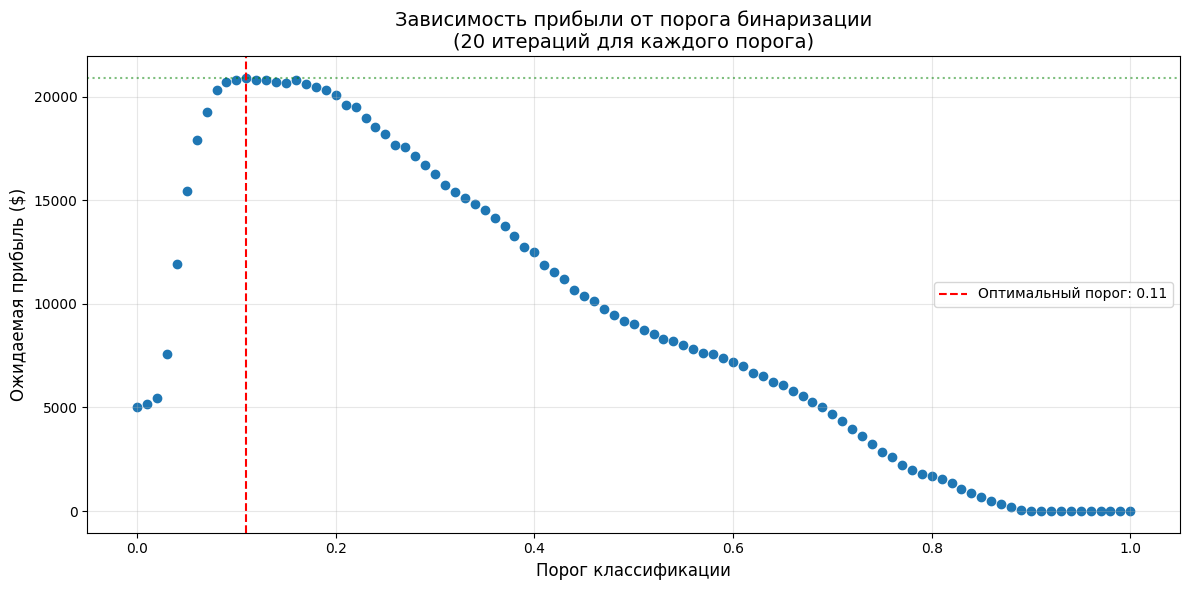

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# Улучшенная функция для расчета прибыли. Здесь дописал для STD
def compute_profit(y_true, y_pred, n_iter=20):
    profit_runs = []
    n_success = np.sum((y_pred == 1) & (y_true == 1))
    n_calls = np.sum(y_pred == 1)
    for _ in range(n_iter):
        client_revenue = np.random.uniform(0, 20, size=n_success)
        profit_runs.append(client_revenue.sum() - n_calls * 1)
    return np.mean(profit_runs), np.std(profit_runs)

# Собираем данные для графика
profit_means = []
profit_stds = []
for threshold in thresholds:
    y_pred_th = (y_proba >= threshold).astype(int)
    mean_profit, std_profit = compute_profit(y, y_pred_th)
    profit_means.append(mean_profit)
    profit_stds.append(std_profit)
# Находим оптимальный порог
best_idx = np.argmax(profit_means)
best_threshold = thresholds[best_idx]
max_profit = profit_means[best_idx]
# Строим график
plt.figure(figsize=(12, 6))
plt.scatter(thresholds, profit_means)
# Выделяем лучший порог
plt.axvline(best_threshold, color='red', linestyle='--',
           label=f'Оптимальный порог: {best_threshold:.2f}')
plt.axhline(max_profit, color='green', linestyle=':', alpha=0.5)

# Настройки графика
plt.xlabel('Порог классификации', fontsize=12)
plt.ylabel('Ожидаемая прибыль ($)', fontsize=12)
plt.title('Зависимость прибыли от порога бинаризации\n(20 итераций для каждого порога)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
print(f"\nОптимальный порог: {best_threshold:.2f}")
print(f"Максимальная прибыль: ${max_profit:.2f} ± ${profit_stds[best_idx]:.2f}")
print(f"Количество звонков при этом пороге: {np.sum(y_proba >= best_threshold)}")
print(f"Доля положительных прогнозов: {np.mean(y_proba >= best_threshold):.2%}")

plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Да, для модели даже при многих запусках наблюдается пик при $x\in[0.1, 0.15]$. Значит то, что модель стабильно имеет наилучшее качество если звонить всем людям, вероятность согласия которых выше примерно 0.11

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Получаем вероятности и предсказания на кросс-валидации
y_proba = cross_val_predict(pipeline, X, y, cv=kf, method='predict_proba')[:, 1]
y_pred_best = (y_proba >= best_threshold).astype(int)

# Функция для кросс-валидационной оценки метрик
def evaluate_metrics(X, y, threshold, cv):
    precisions = []
    recalls = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_proba_fold = pipeline.predict_proba(X_test)[:, 1]
        y_pred_fold = (y_proba_fold >= threshold).astype(int)

        precisions.append(precision_score(y_test, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_fold))

    return np.mean(precisions), np.std(precisions), np.mean(recalls), np.std(recalls)

# Оцениваем метрики
mean_precision, std_precision, mean_recall, std_recall = evaluate_metrics(X, y, best_threshold, kf)

# Выводим результаты
print(f"\nМетрики при пороге {best_threshold:.2f}:")
print("----------------------------------------")
print(f"Precision: {mean_precision:.3f} ± {std_precision:.3f}")
print(f"Recall:    {mean_recall:.3f} ± {std_recall:.3f}")
print("----------------------------------------")
print(f"Интерпретация:")
print(f"- Точность (Precision): {mean_precision*100:.1f}% предсказанных 'да' были верными")
print(f"- Полнота (Recall):    {mean_recall*100:.1f}% реальных 'да' были обнаружены")


Метрики при пороге 0.11:
----------------------------------------
Precision: 0.337 ± 0.012
Recall:    0.641 ± 0.022
----------------------------------------
Интерпретация:
- Точность (Precision): 33.7% предсказанных 'да' были верными
- Полнота (Recall):    64.1% реальных 'да' были обнаружены
